# Predicting AirBnB Review Scores: First Model

Names:
- Artur Rodrigues, arodrigues (at) ucsd (dot) edu 
- Doanh Nguyen, don012 (at) ucsd (dot) edu 
- Ryan Batubara, rbatubara (at) ucsd (dot) edu

## Environment Setup and Package Imports

All packages used in this project are available on Google Colab. The main packages used are:
- matplotlib
- pandas
- regex
- sklearn
- numpy
- seaborn
- plotly
- collections
- itertools
- ast

The data is taken from [Inside AirBnB](https://insideairbnb.com/get-the-data/), but we have combined them into one csv compressed as a 7z file [here](https://drive.google.com/file/d/1DwNaHBBgTesytLoGn23QZMURfK41Du2K/view?usp=sharing) (requires a UCSD account to access, see why below). The data dictionary for this can be found at [Inside AirBnB data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596). It is too large to copy here.

In [1]:
# Main data libraries
import pandas as pd
import numpy as np

# Plotting and dislpay imports
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from IPython.display import display, Markdown

# Data processing imports
import regex as re
import ast
from itertools import chain
from collections import Counter

In [2]:
# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Table of Contents

To summarize, we plan to predict the review scores of a given AirBnB listing given a large number of input features. In this notebook, we do some feature engineering to train a basic regression model to act as a baseline for a better, second model.

This first model notebook will be split into three parts:

- [Data Preprocessing](#data-preprocessing), where we import and process the data.
- [Feature Engineering](#feature-engineering), where we will do feature engineering particularly from categorical columns.
- [Regression Model](#regression-model), where we will train and evaluate a simple model as a baseline for our second model.

Let's get started.

## Data Preprocessing

In [3]:
df_large = pd.read_csv("combined_output.csv", low_memory=False)
Markdown(df_large.head(1).to_markdown()) # Display as Markdown to force all columns to appear

|    |      id | listing_url                          |      scrape_id | last_scraped   | source      | name                       | description                                                                                                                                                            |   neighborhood_overview | picture_url                                                     |   host_id | host_url                                  | host_name   | host_since   | host_location   | host_about                               | host_response_time   | host_response_rate   | host_acceptance_rate   | host_is_superhost   | host_thumbnail_url                                                                                    | host_picture_url                                                                                         |   host_neighbourhood |   host_listings_count |   host_total_listings_count | host_verifications   | host_has_profile_pic   | host_identity_verified   |   neighbourhood | neighbourhood_cleansed   |   neighbourhood_group_cleansed |   latitude |   longitude | property_type      | room_type       |   accommodates |   bathrooms | bathrooms_text   |   bedrooms |   beds | amenities                                                                                                                          | price   |   minimum_nights |   maximum_nights |   minimum_minimum_nights |   maximum_minimum_nights |   minimum_maximum_nights |   maximum_maximum_nights |   minimum_nights_avg_ntm |   maximum_nights_avg_ntm |   calendar_updated | has_availability   |   availability_30 |   availability_60 |   availability_90 |   availability_365 | calendar_last_scraped   |   number_of_reviews |   number_of_reviews_ltm |   number_of_reviews_l30d | first_review   | last_review   |   review_scores_rating |   review_scores_accuracy |   review_scores_cleanliness |   review_scores_checkin |   review_scores_communication |   review_scores_location |   review_scores_value |   license | instant_bookable   |   calculated_host_listings_count |   calculated_host_listings_count_entire_homes |   calculated_host_listings_count_private_rooms |   calculated_host_listings_count_shared_rooms |   reviews_per_month |
|---:|--------:|:-------------------------------------|---------------:|:---------------|:------------|:---------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------:|:----------------------------------------------------------------|----------:|:------------------------------------------|:------------|:-------------|:----------------|:-----------------------------------------|:---------------------|:---------------------|:-----------------------|:--------------------|:------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------|---------------------:|----------------------:|----------------------------:|:---------------------|:-----------------------|:-------------------------|----------------:|:-------------------------|-------------------------------:|-----------:|------------:|:-------------------|:----------------|---------------:|------------:|:-----------------|-----------:|-------:|:-----------------------------------------------------------------------------------------------------------------------------------|:--------|-----------------:|-----------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------:|:-------------------|------------------:|------------------:|------------------:|-------------------:|:------------------------|--------------------:|------------------------:|-------------------------:|:---------------|:--------------|-----------------------:|-------------------------:|----------------------------:|------------------------:|------------------------------:|-------------------------:|----------------------:|----------:|:-------------------|---------------------------------:|----------------------------------------------:|-----------------------------------------------:|----------------------------------------------:|--------------------:|
|  0 | 2992450 | https://www.airbnb.com/rooms/2992450 | 20240607164239 | 2024-06-07     | city scrape | Luxury 2 bedroom apartment | The apartment is located in a quiet neighborhood . Fully furnished. Linens and towels are provided. It's two blocks away from downtown Albany, and the Palace theater. |                     nan | https://a0.muscache.com/pictures/44627226/0e72c75c_original.jpg |   4621559 | https://www.airbnb.com/users/show/4621559 | Kenneth     | 2013-01-07   | New York, NY    | I am a real down to earth & cool person. | within a few hours   | 100%                 | 100%                   | f                   | https://a0.muscache.com/im/users/4621559/profile_pic/1363081467/original.jpg?aki_policy=profile_small | https://a0.muscache.com/im/users/4621559/profile_pic/1363081467/original.jpg?aki_policy=profile_x_medium |                  nan |                     1 |                           5 | ['email', 'phone']   | t                      | f                        |             nan | THIRD WARD               |                            nan |    42.6579 |    -73.7537 | Entire rental unit | Entire home/apt |              4 |           1 | 1 bath           |          2 |      2 | ["Essentials", "Air conditioning", "Wifi", "Kitchen", "TV with standard cable", "Smoke alarm", "Carbon monoxide alarm", "Heating"] | $70.00  |               28 |             1125 |                       28 |                       28 |                     1125 |                     1125 |                       28 |                     1125 |                nan | t                  |                 0 |                 0 |                 0 |                 68 | 2024-06-07              |                   9 |                       0 |                        0 | 2014-07-01     | 2022-08-17    |                   3.56 |                     3.44 |                        3.56 |                    4.22 |                          4.56 |                     3.22 |                  3.67 |       nan | f                  |                                1 |                                             1 |                                              0 |                                             0 |                0.07 |

### Dropping Unecessary Columns

Some columns in the original data are unecessary for our purposes. For a detailed description of each column, see the [Inside AirBnB Data Dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596).

We list reasons for dropping these columns:
- `All URL`: Unique elements for each listing. Does not contribute anything when predicting the review score.

- `All ID`: Unique elements for each listing. Does not contribute anything when predicting the review score.

- `host_name`: Indiviudally unique elements for each listing. Does not contribute anything when predicting the review score.

- `license`: Unique elements for each listing. Does not contribute anything when predicting the review score.

- `source`: Holds whether or not the listing was found via searching by city or if the listing was seen in a previous scrape. There is no logical
connection between this and the target variable, which is review score.

- `host_location`: Private information.

- `host_total_listings_count`: There exists another feature called `host_listings_count`, this is a duplicate feature.

- `calendar_last_scarped`: Holds the date of the last time the data was scrapped, no logical connection between this and predicting `review_score_rating`.

- `first & last review`: provides temporal data for the first & last review date. Last review date can be misleading as an unpopular listing may have no reviews for an extended amount of time, and suddenly get a review.

- `minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights`: The all time minimum and maximum of a listing's minimum and maximum nights requirement for booking. This has no correlation to review score because you cannot write a review if you have not stayed at the listing. A person who wants to book a listing for 10 days is not going to book a listing that has a maximum night stay of 9 days.

In [4]:
df_dropped = df_large.drop(columns=[
    'listing_url', 
    'host_listings_count',
    'scrape_id', 
    'picture_url', 
    'host_id', 
    'host_url', 
    'host_name', 
    'host_thumbnail_url',
    'host_picture_url', 
    'minimum_minimum_nights',
    'maximum_minimum_nights', 
    'minimum_maximum_nights',
    'maximum_maximum_nights', 
    'calendar_updated',
    'license',
    'calendar_last_scraped',
    'id',
    'source',
    'host_location',
    'host_total_listings_count',
    'first_review',
    'last_review'
])

### Dropping 0 Review Listings

Since we are trying to predict AirBnB review scores (for the purpose of finding out what makes a good review score), we will be dropping all listings that have 0 reviews. This is because, from the perspective of our model, these rows do not provide any meaningful information into what makes a highly rated listing (since their review scores are `NaN`, and are missing by design).

We remark that this still leaves us with almost 200 thousand rows, so the data remains large enough for a model.

In [5]:
df_nonzero = df_dropped[df_dropped['number_of_reviews'] > 0]
df_dropped.shape, df_nonzero.shape

((276371, 53), (217171, 53))

### Fixing Datatypes

Some columns have incorrect datatypes, such as:
- `host_response_rate` and `host_acceptance_rate` should be change from a `str` percent to a `float`.
- `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `has_availability`, `instant_bookable` should be booleans.
- `last_scraped` and `host_since` should be Pandas timestamps.
- `price` should be a float in dollars.
- `amenities` and `host_verifications` should be a list.

In [6]:
df = df_nonzero.copy()

df['host_response_rate'] = df['host_response_rate'].str.strip("%").astype('float') / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.strip("%").astype('float') / 100
df['description'] = df['description'].astype(str)

bool_dict = {'t':True, 'f':False}
df['host_is_superhost'] = df['host_is_superhost'].replace(bool_dict)
df['host_has_profile_pic'] = df['host_has_profile_pic'].replace(bool_dict)
df['host_identity_verified'] = df['host_identity_verified'].replace(bool_dict)
df['has_availability'] = df['has_availability'].replace(bool_dict)
df['instant_bookable'] = df['instant_bookable'].replace(bool_dict)

df['last_scraped'] = pd.to_datetime(df['last_scraped'], format="%Y-%m-%d")
df['host_since'] = pd.to_datetime(df['host_since'], format="%Y-%m-%d")

df['price'] = df['price'].str.strip("$").str.replace(',','').astype('float')

df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['host_verifications'] = df['host_verifications'].apply(lambda x: [] if x is np.nan else ast.literal_eval(x))

Markdown(df.head(1).to_markdown())

C:\Users\ryany\AppData\Local\Temp\ipykernel_14548\3016406255.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['instant_bookable'] = df['instant_bookable'].replace(bool_dict)


|    | last_scraped        | name                       | description                                                                                                                                                            |   neighborhood_overview | host_since          | host_about                               | host_response_time   |   host_response_rate |   host_acceptance_rate | host_is_superhost   |   host_neighbourhood | host_verifications   | host_has_profile_pic   | host_identity_verified   |   neighbourhood | neighbourhood_cleansed   |   neighbourhood_group_cleansed |   latitude |   longitude | property_type      | room_type       |   accommodates |   bathrooms | bathrooms_text   |   bedrooms |   beds | amenities                                                                                                                          |   price |   minimum_nights |   maximum_nights |   minimum_nights_avg_ntm |   maximum_nights_avg_ntm | has_availability   |   availability_30 |   availability_60 |   availability_90 |   availability_365 |   number_of_reviews |   number_of_reviews_ltm |   number_of_reviews_l30d |   review_scores_rating |   review_scores_accuracy |   review_scores_cleanliness |   review_scores_checkin |   review_scores_communication |   review_scores_location |   review_scores_value | instant_bookable   |   calculated_host_listings_count |   calculated_host_listings_count_entire_homes |   calculated_host_listings_count_private_rooms |   calculated_host_listings_count_shared_rooms |   reviews_per_month |
|---:|:--------------------|:---------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------:|:--------------------|:-----------------------------------------|:---------------------|---------------------:|-----------------------:|:--------------------|---------------------:|:---------------------|:-----------------------|:-------------------------|----------------:|:-------------------------|-------------------------------:|-----------:|------------:|:-------------------|:----------------|---------------:|------------:|:-----------------|-----------:|-------:|:-----------------------------------------------------------------------------------------------------------------------------------|--------:|-----------------:|-----------------:|-------------------------:|-------------------------:|:-------------------|------------------:|------------------:|------------------:|-------------------:|--------------------:|------------------------:|-------------------------:|-----------------------:|-------------------------:|----------------------------:|------------------------:|------------------------------:|-------------------------:|----------------------:|:-------------------|---------------------------------:|----------------------------------------------:|-----------------------------------------------:|----------------------------------------------:|--------------------:|
|  0 | 2024-06-07 00:00:00 | Luxury 2 bedroom apartment | The apartment is located in a quiet neighborhood . Fully furnished. Linens and towels are provided. It's two blocks away from downtown Albany, and the Palace theater. |                     nan | 2013-01-07 00:00:00 | I am a real down to earth & cool person. | within a few hours   |                    1 |                      1 | False               |                  nan | ['email', 'phone']   | True                   | False                    |             nan | THIRD WARD               |                            nan |    42.6579 |    -73.7537 | Entire rental unit | Entire home/apt |              4 |           1 | 1 bath           |          2 |      2 | ['Essentials', 'Air conditioning', 'Wifi', 'Kitchen', 'TV with standard cable', 'Smoke alarm', 'Carbon monoxide alarm', 'Heating'] |      70 |               28 |             1125 |                       28 |                     1125 | True               |                 0 |                 0 |                 0 |                 68 |                   9 |                       0 |                        0 |                   3.56 |                     3.44 |                        3.56 |                    4.22 |                          4.56 |                     3.22 |                  3.67 | False              |                                1 |                                             1 |                                              0 |                                             0 |                0.07 |

For utility, we create a list of all the text and categorical columns 

In [7]:
text_cat_cols = list(filter(lambda x: x not in df.select_dtypes(np.number).columns, df.columns))
text_cat_cols

['last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'host_since',
 'host_about',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'instant_bookable']

## Feature Engineering

For the numerical columns, we will normalize the data, as we believe these speak for themselves as features. However, we cannot simply pass categorical columns into a regression model. Thus, we go through some of the most important categorical columns (in no particular order) and consider various ways of encoding them into a numerical feature.

### Feature 1: Name

The feature we are looking at is called `names` which holds the name of an airbnb listing. We decided to look for my most common words found throughout each name, and throughout names of listings with review scores of 4.9 or above and 100 reviews or above, to try and single out higlighly rated and popular listings. 

The issue with this is that the most common words found throughout all the names of each listing are words such as `the`, `in`, `etc` - words that really have no meaning without context. For example, the word `in` is the most popular word throughout all the listing's names, but it simply has no meaning without context, so we decided to look at the top 200 words and filter and select words that can be used individually. After filtering the top 200 words and using a regression plot between the relationship between the target variable, review_scores_rating, and names feature, we can see that they have a positive linear relationship, indicating that names is an impactful feature when predicting the target variable. 

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
class SubstringsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, substrings):
        self.substrings = substrings
        self.substrings_regex = "|".join(substrings)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, (pd.DataFrame)):
            return X.map(self._count_substrings).to_numpy()
        elif isinstance(X, (pd.Series)):
            return pd.DataFrame(X.apply(self._count_substrings)).to_numpy()
        else:
            raise ValueError(f"Unsupported data type: {type(X)}")
        
    def _count_substrings(self, s):
        if not isinstance(s, str):
            s = str(s)
        return len(re.findall(self.substrings_regex, s))

In [9]:
trans = SubstringsTransformer(['private','cozy','retreat'])
trans.fit_transform(df[['name']].astype(str)).mean()

0.033259505182551996

In [10]:
df_good = df[(df['review_scores_rating'] >= 4.9) & (df['number_of_reviews'] >= 100)]
df_good.shape # Number of really good listings based on our definition

(16161, 53)

In [11]:
def count_words(df_here, col):
    """ Counts ths number of words in the given col and DataFrame """
    # Count most common words as proportions in the good listings
    text = ' '.join(df_here[col].convert_dtypes(str).dropna())
    words = re.findall(r'\b\w+\b', text.lower())
    name_count = Counter(words)

    # Convert to dataframe
    name_df = (pd.DataFrame.from_dict(
        name_count, 
        orient='index', 
        columns=['count']
    )   
        .reset_index()
        .rename(columns={'index': 'word'})
        .sort_values(by='count', ascending=False)
    )

    # Normalize as proportion and add rank
    name_df['count_prop'] = name_df['count'] / name_df['count'].sum()
    name_df['rank'] = name_df['count_prop'].rank(ascending=False)

    return name_df

In [12]:
good_name_df = count_words(df_good, 'name')
all_name_df = count_words(df, 'name')

# Merge the dataframes
name_df = (pd.merge(
    good_name_df, all_name_df, 
    on='word',
    how='outer', 
    suffixes=('_good','_all')
)
    .sort_values(by='count_good', ascending=False)
)

name_df.head(10)

,word,count_good,count_prop_good,rank_good,count_all,count_prop_all,rank_all
16338,in,2973.0,0.027643,1.0,37581,0.026288,1.0
23488,private,2496.0,0.023208,2.0,23470,0.016417,2.0
28152,to,2064.0,0.019191,3.0,23467,0.016415,3.0
27935,the,1975.0,0.018364,4.0,21632,0.015132,4.0
15708,home,1474.0,0.013706,5.0,20676,0.014463,6.0
15909,house,1350.0,0.012553,6.0,12499,0.008743,17.0
30256,with,1302.0,0.012106,7.0,16775,0.011734,11.0
7357,beach,1210.0,0.011251,8.0,17934,0.012545,9.0
27143,studio,1199.0,0.011149,9.0,15646,0.010944,12.0
27286,suite,1197.0,0.011130,10.0,10091,0.007059,23.0


In [13]:
name_df['word'].head(1000).to_csv("names.csv", index=False)

In [14]:
names_meaningful = [
    'private',
    'cozy',
    'downtown',
    'parking',
    'retreat',
    'view',
    'spacious',
    'views',
    'charming',
    'luxury',
    'beautiful',
    'new',
    'quiet',
    'clean',
    'bright',
]

<Axes: xlabel='name', ylabel='review_scores_rating'>

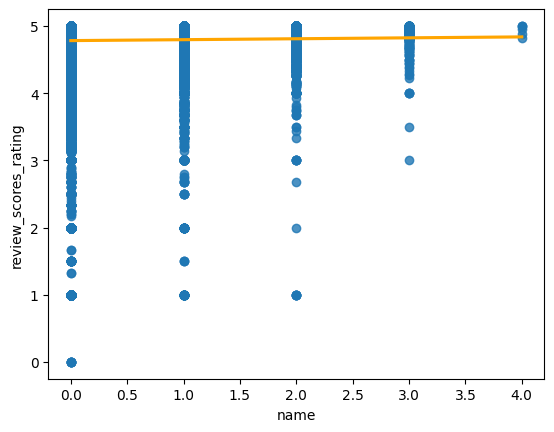

In [15]:
counts = df['name'].str.count('|'.join(names_meaningful))
sns.regplot(
    x=counts[counts <= 10],
    y=df['review_scores_rating'][counts <= 10],
    line_kws=dict(color="orange")
)

### Feature 2: Length of Amenities


The datatype of `amenities` is a list of strings listing all the amenities an airbnb listing has. In order to use this feature, we decided to plot the linear regression relationship between the target variable `review_scores_rating` and the length of the `amenities` list (the bigger the length, the more amenities a listing has). We see that the more amenities a listing has, the higher the review_score_rating is, indicating a positive correlation between the two parameters. 

In [16]:
df['amenities']

0         [Essentials, Air conditioning, Wifi, Kitchen, ...
1         [Free washer – In unit, Free parking on premis...
2         [Lockbox, Dedicated workspace, Self check-in, ...
3         [Washer, Self check-in, Keypad, Microwave, Hai...
4         [Kitchen, Exterior security cameras on propert...
                                ...                        
276350    [Blender, Free dryer – In unit, Wifi, Carbon m...
276352    [Suave shampoo, Toaster, Dedicated workspace, ...
276354    [Dedicated workspace, Wifi, Carbon monoxide al...
276355    [Dedicated workspace, Washer, Wifi, Smoke alar...
276370    [Toaster, Dedicated workspace, Baking sheet, W...
Name: amenities, Length: 217171, dtype: object

<Axes: xlabel='amenities', ylabel='review_scores_rating'>

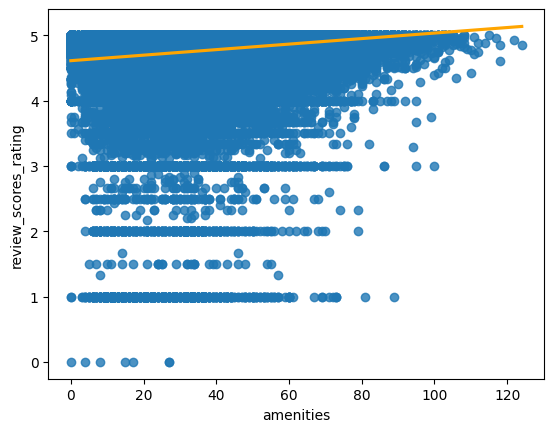

In [17]:
sns.regplot(
    x=df['amenities'].apply(len),
    y=df['review_scores_rating'],
    line_kws=dict(color="orange")
)

We create a sklearn transformer to more easily integrate this into our model.

In [18]:
class LengthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, (pd.DataFrame)):
            return X.map(len).to_numpy()
        elif isinstance(X, (pd.Series)):
            return pd.DataFrame(X.apply(len)).to_numpy()
        else:
            raise ValueError(f"Unsupported data type: {type(X)}")

In [19]:
trans = LengthTransformer()
trans.fit_transform(df['amenities']).mean()

40.02224514322815

### Feature 3: Host Verifications

The column `host_verifications` tells the user which method of communication of the host is vertified. To work with this feature, we decided to encode the length of all the list, since it would be difficult to determine whether it is more valuable to have one type of verification than the other, but it is relatively sensible that more verifications imply a more communicative host. 

We then plotted a regression plot and based on the graph, and we observed that the relationship between `host_vertifications` and `review_scores_rating` is pretty flat, indicating that `host_vertification` has a weak correlation to `review_scores_rating`, making it a unreliable feature. Hence we are dropping it i.e. not using it in our model.

This makes sense, since someone is unlikely to rate a listing higher just because say the host is accesible through two email adresses instead of one.

In [20]:
df['host_verifications'].value_counts()

host_verifications
[email, phone]                              170359
[email, phone, work_email]                   30482
[phone]                                      15112
[phone, work_email]                            999
[email]                                        141
[]                                              59
[email, work_email]                             10
[email, phone, photographer]                     8
[email, phone, photographer, work_email]         1
Name: count, dtype: int64

<Axes: xlabel='host_verifications', ylabel='review_scores_rating'>

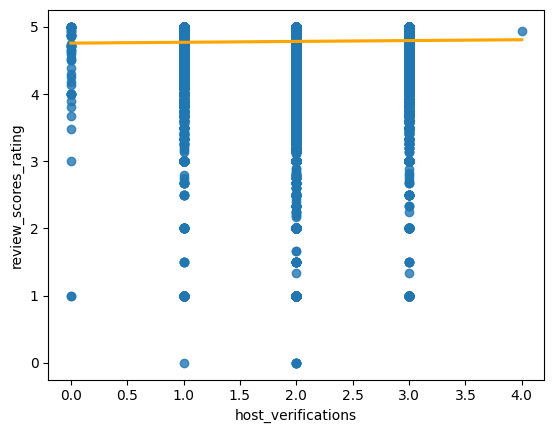

In [21]:
sns.regplot(
    x=df['host_verifications'].apply(lambda x: 0 if x is np.nan else len(x)),
    y=df['review_scores_rating'],
    line_kws=dict(color="orange")
)

### Feature 4: Description

The data type is a long string that holds a detailed descrition of an airbnb listing. We decided to employ the same encoding method as the names feature - we find the most common words in the good listings (those with review scores above 4.9 and at least 100 reviews) and compare them to their prevalence amongst all listings.

We plotted a regression plot between the `description` feature and `review_score_rating`. We noticed that it as a positive regression line, indicating that listings with the the most popular description words in it have a higher `review_score_rating`, indicating that description is a good predictor of the target variable.

In [22]:
df['description']

0         The apartment is located in a quiet neighborho...
1         Cozy, cool little 1BR Apt in the heart Albany'...
2         Spacious studio with hardwood floors, fully eq...
3         Large renovated 1 bedroom apartment in convert...
4         Stunningly renovated French Victorian original...
                                ...                        
276350    1BR in the heart of Capitol Hill. Enjoy modern...
276352    If you’re looking for an escape from the hustl...
276354    Discover your cozy urban haven in the South Ea...
276355    1 bed and bathroom space in the heart of Georg...
276370    The unit has a king bed, a bunk bed, one sofa ...
Name: description, Length: 217171, dtype: object

In [23]:
good_desc_df = count_words(df_good, 'description')
all_desc_df = count_words(df, 'description')

# Merge the dataframes
desc_df = (pd.merge(
    good_desc_df, all_desc_df, 
    on='word',
    how='outer', 
    suffixes=('_good','_all')
)
    .sort_values(by='count_good', ascending=False)
)

desc_df.head(200)

,word,count_good,count_prop_good,rank_good,count_all,count_prop_all,rank_all
51964,the,46068.0,0.038441,1.0,548240,0.038686,1.0
9508,and,44155.0,0.036844,2.0,528386,0.037285,2.0
7906,a,33236.0,0.027733,3.0,382937,0.027021,4.0
13588,br,32005.0,0.026706,4.0,401361,0.028322,3.0
52557,to,30563.0,0.025503,5.0,356066,0.025125,5.0
...,...,...,...,...,...,...,...
49582,st,943.0,0.000787,196.0,7901,0.000558,291.0
45043,right,942.0,0.000786,197.0,12580,0.000888,182.0
45875,safe,936.0,0.000781,198.0,10160,0.000717,216.0
15638,centrally,932.0,0.000778,199.0,18636,0.001315,121.0


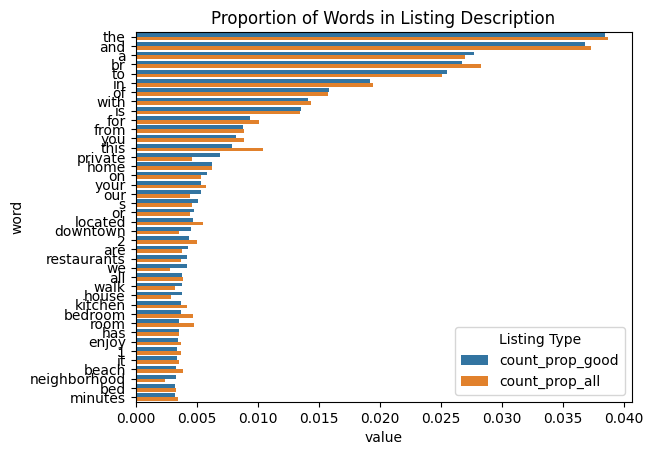

In [24]:
desc_melted_df = desc_df.head(40).melt(
    id_vars='word',
    value_vars=['count_prop_good','count_prop_all'],
    var_name='Listing Type',
    value_name='value'
)

ax = sns.barplot(
    desc_melted_df,
    x='value',
    y='word',
    hue='Listing Type',
)

ax.set_title('Proportion of Words in Listing Description')

plt.show()

In [25]:
desc_meaningful = [
    'private',
    'home',
    'downtown',
    'restaurants',
    'house',
    'kitchen',
    'beach',
    'neighborhood',
    'parking',
    'apartment',
    'modern',
    'walking',
    'shops',
    'distance',
    'city',
    'close',
    'tv',
    'cozy',
    'studio',
    'spacious',
    'comfortable',
    'views',
    'bars',
    'renovated',
    'airport',
    'wifi',
    'garden',
    'dining',
    'pool',
    'shopping',
]

In [26]:
trans = SubstringsTransformer(desc_meaningful)
desc_transformed = trans.fit_transform(df[['description']])

<Axes: ylabel='review_scores_rating'>

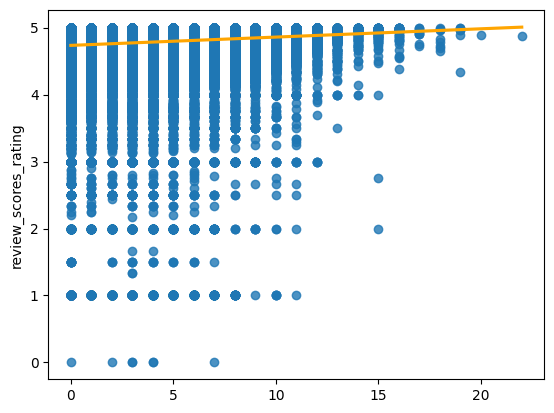

In [27]:
sns.regplot(
    x=desc_transformed,
    y=df['review_scores_rating'],
    line_kws=dict(color="orange")
)

### Feature 5: Host About

The column `host_about` contains a string blurb of the host's description, such as their lifestyle or preferences.

In the graph below we have plotted the proportions of how often the top 40 most frequent words show up in the `host_about` feature both for the good listings (review scores above 4.9 and at least 100 reviews) and for all listings. As indicated by the legend, the blue bars indicate the proportions of the words in the good listings, and the orange bars indicate the proportions of the words all listings.

For words like 'and' where the blue bar is noticeably longer than the orange bar, this indicates that the good listings have this word included in the `host_about` feature with a higher frequency when compared to all listings. In the opposite scenario, such as for words like 'you', where the orange bar is noticeably longer than the blue bar, this indicates that the good listings have this word included in the `host_about` feature with a lower frequency when compared to all listings.

If it were the case that many of the 40 most frequent words in the `host_about` feature fell into one of two previously described scenarios, then this would indicate to us that this feature most likely plays a role in determining the quality (in terms of review ratings) of a listing. In reality, however, we see that few of the top 40 most frequent words actually have a noticeable/relevant different in the length of the blue and orange bars, which is a strong indication that this feature is actually not all that useful when it comes to determining the review rating of a listing.

Due to the aforementioned reasons, we are not going to be using this feature for our model as it does not seem to be helpful in determining the review rating of a listing.

In [28]:
good_about_df = count_words(df_good, 'host_about')
all_about_df = count_words(df, 'host_about')

# Merge the dataframes
about_df = (pd.merge(
    good_about_df, all_about_df, 
    on='word',
    how='outer', 
    suffixes=('_good','_all')
)
    .sort_values(by='count_good', ascending=False)
)

about_df.head(200)

,word,count_good,count_prop_good,rank_good,count_all,count_prop_all,rank_all
3082,and,43551.0,0.050905,1.0,412018,0.046149,1.0
19559,i,28897.0,0.033776,2.0,243780,0.027305,4.0
39689,to,27671.0,0.032343,3.0,296822,0.033246,2.0
39257,the,25110.0,0.029350,4.0,247198,0.027688,3.0
1510,a,20423.0,0.023871,5.0,212610,0.023814,5.0
...,...,...,...,...,...,...,...
19161,hospitality,607.0,0.000709,196.0,9984,0.001118,132.0
512,2,606.0,0.000708,197.0,5383,0.000603,238.0
28869,outdoors,605.0,0.000707,198.0,3908,0.000438,314.0
16056,free,601.0,0.000702,199.5,10967,0.001228,119.5


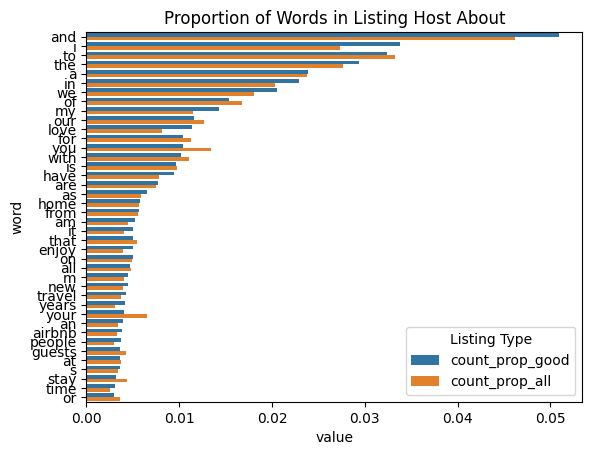

In [29]:
about_melted_df = about_df.head(40).melt(
    id_vars='word',
    value_vars=['count_prop_good','count_prop_all'],
    var_name='Listing Type',
    value_name='value'
)

ax = sns.barplot(
    about_melted_df,
    x='value',
    y='word',
    hue='Listing Type',
)

ax.set_title('Proportion of Words in Listing Host About')

plt.show()

### Feature 6: Property Type

When it comes to the `property_type` feature, we trained our model using only this feature and when we look at the r^2 score for our model, we get 0.02993098364575919. The r^2 score can be seen as a continuous value in the interval [0, 1] which indicates how good this feature is at helping our model predict the reivew rating for a listing where 0 means bad and 1 means good. The score we got isn't good but its not like this feature is insignificant either. It is important to keep in mind that this is only a single feature for our model, so while it's r^2 score is relatively low, it is still a contributing to our model's ability/success in predicting a listing's review rating, thus we are going to be keeping this feature.

In [30]:
df['property_type']

0           Entire rental unit
1           Entire rental unit
2           Entire rental unit
3           Entire rental unit
4                  Entire home
                  ...         
276350      Entire rental unit
276352             Entire home
276354      Entire rental unit
276355    Private room in home
276370      Entire rental unit
Name: property_type, Length: 217171, dtype: object

In [31]:
mdl = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    LinearRegression()
)

mdl.fit(df[['property_type']],df['review_scores_rating'])
mdl.score(df[['property_type']],df['review_scores_rating'])
# This is r^2 score, from bad (0) to perfect (1)

0.02993098364575919

### Feature 7: Room Type

For `room_type` we did the same thing that we did above for `property_type`, however, this time for our r^2 score we got 0.009426732792224835 for `room_type`. This is substantially lower than our r^2 score for `property_type`, so much so, that we are not going to be using this feature as it seems to be playing a very minimal, almost negligible, role in helping our model predict a listing's review rating.

In [32]:
df.room_type.value_counts()

room_type
Entire home/apt    169923
Private room        44957
Shared room          1410
Hotel room            881
Name: count, dtype: int64

In [33]:
mdl.fit(df[['room_type']],df['review_scores_rating'])
mdl.score(df[['room_type']],df['review_scores_rating'])
# This is r^2 score, from bad (0) to perfect (1)

0.009426732792224835

### Feature 8: Host Since

For the feature `host_since` we have plotted, in the above graph, the number of weeks that a host has been on the platform on the x-axis versus the `review_scores_rating` feature on the y-axis. We can see a small, but not insignificant, positive correlation between the two, which indicates that the longer a host has been on the platform, the higher their review rating tends to be. For this reason, we are going to be keeping this feature as it is most likely going to help our model in predicting a listing's review rating based on the how long the host has been on the platform.

In [34]:
host_weeks = (pd.Timestamp('2024-07-31') - df['host_since']) / pd.Timedelta(weeks=1)
host_weeks.describe()

count    217164.000000
mean        378.767246
std         173.662443
min           5.285714
25%         255.142857
50%         405.000000
75%         502.857143
max         856.285714
Name: host_since, dtype: float64

<Axes: xlabel='host_since', ylabel='review_scores_rating'>

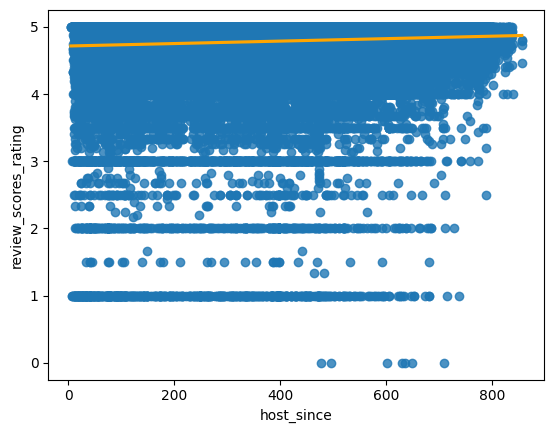

In [35]:
sns.regplot(
    x=host_weeks,
    y=df['review_scores_rating'],
    line_kws=dict(color="orange")
)

We make another sklearn transformer to more easily integrate this feature into our model.

In [36]:
class WeekTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, (pd.DataFrame)):
            return pd.DataFrame((pd.Timestamp('2024-07-31') - X) / pd.Timedelta(weeks=1)).to_numpy()
        elif isinstance(X, (pd.Series)):
            return pd.DataFrame((pd.Timestamp('2024-07-31') - X) / pd.Timedelta(weeks=1)).to_numpy()
        else:
            raise ValueError(f"Unsupported data type: {type(X)}")

In [37]:
pl = WeekTransformer()
pd.Series(pl.fit_transform(df['host_since']).ravel()).mean()

378.76724634706625

### Feature 9: Host Response Time and Rate

For `host_response_time`, as we did with `room_type` and `property_type`, we used this feature to train our model and then got an r^2 score, this time of 0.002128186367516438. Similar to `room_type` this is a very low r^2 score which indicates to us that this feature is not very relevant in our model's prediction of a listing's review rating, thus we are not going to be using this feature.

This makes sense - there are only four classes of values in this column, and they don't tell us very much either. For example, a listing that is only popular in the summer may have a host that responds quickly in the summer, but does not even open AirBnb in the winter - such hosts may have a response time of a few days or more despite delivering highly rated listings.

In [38]:
df['host_response_time'].value_counts()

host_response_time
within an hour        155557
within a few hours     20263
within a day            9249
a few days or more      2939
Name: count, dtype: int64

In [39]:
mdl.fit(df[['host_response_time']],df['review_scores_rating'])
mdl.score(df[['host_response_time']],df['review_scores_rating'])

0.002128186367516438

### Feature 10: Host Profile Pic

For `host_profile_pic`, as we did with `room_type`, `property_type`, and `host_response_time`, we used this feature to train our model and then got an r^2 score, this time of 0.0006544772136575228. Similar to `room_type` this is a very low r^2 score which indicates to us that this feature is not very relevant in our model's prediction of a listing's review rating, thus we are not going to be using this feature.

In [40]:
df['host_has_profile_pic'].value_counts()

host_has_profile_pic
True     214390
False      2774
Name: count, dtype: int64

In [41]:
mdl.fit(df[['host_has_profile_pic']],df['review_scores_rating'])
mdl.score(df[['host_has_profile_pic']],df['review_scores_rating'])

0.0006544772136575228

## First Model: Linear Regression

### Choosing a First Model

At this point, we have two groups of features:
- Categorical Columns, encoded into some sort of numerical feature as described in the previous section.
- Numerical Columns, which is essentially every other feature in our dataset.

We plan to put all of these features into a LinearRegression model from sklearn. There are three main reasons a LinearRegression model is ideal for our base model:
1. It is relatively simple, and features almost entirely dictate how well the model performs. This allows us to focus on enginnering good, relevant features for our second, more complicated model.
2. LinearRegression allows us to check the coefficient of every variable, and when standardized or normalized, a sense of which features play the largest role in determining the review score.
3. It is extremely fast and easy to implement LinearRegression, allowing us to test many different features and encodings quickly.

As such, let's begin by creating a sklearn preprocessor for our data.

In [42]:
review_cols = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

In [43]:
numeric_features = df.drop(columns=review_cols+['host_since']).select_dtypes(np.number).columns

In [45]:
preproc = make_column_transformer(
    (SubstringsTransformer(names_meaningful), 'name'),
    (SubstringsTransformer(desc_meaningful), 'description'),
    (WeekTransformer(), 'host_since'),
    (LengthTransformer(), 'host_verifications'),
    (OneHotEncoder(handle_unknown='ignore'), ['property_type']),
    (OneHotEncoder(handle_unknown='ignore'), ['room_type']),
    (LengthTransformer(), 'amenities'),
    (StandardScaler(), numeric_features)
)

The above preprocessor simply applies the given transformer to the columns on the second item in the tuple. As such, all that is left to do is to put this preprocessor into a pipeline alongside our model. Note however, that sklearn cannot support missing values, and so we will conduct mean imputation for these missing values. This is because LinearRegression (based on minimizing mean_square_error) will not get any better nor any worse if a data point with all mean values is added or removed from the dataset.

In [46]:
model = make_pipeline(
    preproc, 
    SimpleImputer(strategy='mean'),
    LinearRegression()
)

### Model Evaluation

We now do 10-fold cross validaton and report the metrics for each fold.

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X = df.drop(columns=review_cols)
y = df['review_scores_rating']

scores = {}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X)):

    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)
    y_train_pred_fold = model.predict(X_train_fold)
    y_test_pred_fold = model.predict(X_test_fold)
    
    scores[i] = {}
    scores[i]['train'] = {
        'mean_squared_error': mean_squared_error(y_train_fold, y_train_pred_fold),
        'mean_absolute_error': mean_absolute_error(y_train_fold, y_train_pred_fold),
        'r2_score': r2_score(y_train_fold, y_train_pred_fold)
    }
    scores[i]['test'] = {
        'mean_squared_error': mean_squared_error(y_test_fold, y_test_pred_fold),
        'mean_absolute_error': mean_absolute_error(y_test_fold, y_test_pred_fold),
        'r2_score': r2_score(y_test_fold, y_test_pred_fold)
    }

We have the mse, mae, and r2 for the test and train of each fold. Here, we display the average of each category as well as all the values to show that this model, though not very good, generalizes well across the data.

In [40]:
scores_df = pd.DataFrame.from_dict(
    {(i, k): scores[i][k]
    for i in scores.keys()
    for k in scores[i].keys()},
    orient='index'
)
scores_df

mean_squared_error  mean_absolute_error  r2_score
0 train            0.126130             0.198191  0.087947
  test             0.130564             0.200480  0.085520
1 train            0.127414             0.199016  0.087206
  test             0.118979             0.195752  0.092482
2 train            0.126681             0.198671  0.087563
  test             0.125549             0.196630  0.089308
3 train            0.127029             0.198596  0.087552
  test             0.123754             0.197797  0.079530
4 train            0.126899             0.198766  0.088065
  test             0.123835             0.196832  0.082805
5 train            0.125540             0.197758  0.088104
  test             0.135944             0.203179  0.083654
6 train            0.126947             0.198569  0.087876
  test             0.123132             0.198147  0.086635
7 train            0.126227             0.198311  0.087430
  test             0.129676             0.198832  0.090059
8 train            0.126344             0.198277  0.087910
  test             0.128622             0.199914  0.085905
9 train            0.126359             0.198572  0.088499
  test             0.128394             0.198563  0.081268

In [42]:
average_df = scores_df.groupby(level=1).mean()
average_df

,mean_squared_error,mean_absolute_error,r2_score
test,0.126845,0.198613,0.085717
train,0.126557,0.198473,0.087815


We will now interpret the above metrics in more detail. We start with the `mean_absolute_error`, which tells us that on average our predicted rating is 0.19 off for both the test and train cases. The similarity between these values tell us that our model has not overfitted, but the large values (considering review ratings go from 0 to 5 only) show us that the model is not very good.

Same can be said for our `mean_squared_error`. We note that its value is smaller than the `mean_absolute_error`, which makes sense as it is roughly the square root of the `mean_absolute_error`.

The `r2_score` however tells a very interesting story. The `r2_score` is a correlation metric that goes from 0 to 1, where 0 implies no correlation and 1 is identical correlation. Our low value of 0.08 tells us that despite the large number of features, we still have not effectively represented the data. This makes sense - it is very hard to even describe in words what would make one AirBnb listing more highly rated than the other. However, this also gives us plenty of room to improve in our second model.

### Model on Fitting Graph

Based on our relatively high MSE, and generally almost identical test and train MSE, MAE, and r2, it is safe to say that our model is not that far along the fitting graph. In other words, our model has not overfitted the data since we see very similar values between the test and train metrics. This is very good for us, as there is much room to add more model complexity - such as by adding more features, or changing to a more complex model - and improve the metrics in our second, better model.

To further drive this point, we print out the differences between the test and train for every fold and every metric.

In [49]:
difference_df = scores_df.xs('train', level=1) - scores_df.xs('test', level=1)
difference_df.index = pd.MultiIndex.from_product([difference_df.index])
difference_df

,mean_squared_error,mean_absolute_error,r2_score
0,-0.004434,-0.002290,0.002427
1,0.008435,0.003265,-0.005276
2,0.001132,0.002041,-0.001744
3,0.003275,0.000799,0.008021
4,0.003064,0.001934,0.005260
5,-0.010404,-0.005421,0.004450
6,0.003814,0.000422,0.001241
7,-0.003449,-0.000521,-0.002629
8,-0.002278,-0.001637,0.002005
9,-0.002035,0.000009,0.007232


In [54]:
average_difference_df = difference_df.mean()
average_difference_df

mean_squared_error    -0.000288
mean_absolute_error   -0.000140
r2_score               0.002099
dtype: float64

Indeed, the difference is very small and thus it supports our claim.

### Coefficient Analysis

To better visualize our model, we create the following diagram of sklearn transformers that go into our Linear Regression.

In [47]:
model = make_pipeline(
    preproc, 
    SimpleImputer(strategy='mean'),
    LinearRegression()
)
model.fit(df.drop(columns=review_cols),df['review_scores_rating'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('substringstransformer-1',
                                                  SubstringsTransformer(substrings=['private',
                                                                                    'cozy',
                                                                                    'downtown',
                                                                                    'parking',
                                                                                    'retreat',
                                                                                    'view',
                                                                                    'spacious',
                                                                                    'views',
                                                                                    'charming',
                                                                                    'luxury',
                                                                                    'beautiful',
                                                                                    'new',
                                                                                    'quiet',
                                                                                    'clean',
                                                                                    'bright']),
                                                  'name'),
                                                 ('substringstransformer-2',
                                                  SubstringsTransformer(substrings=['private',
                                                                                    'h...
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object'))])),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In the previous section, we found that our model has a very low `r2_score`. This means that none of our input features are particularly correlated with the review score. To better drive this point, we explore what the average coefficient is in our linear model.

Since the vairables are all normalized, we should expect these coefficients to almost directly correlate to the review score. For example, a coefficient of 0.01 means for each unit of that column, we would increase the review score by 0.01.

In [53]:
coefs = pd.Series(np.abs(model.named_steps['linearregression'].coef_))
coefs.describe()

count    159.000000
mean       0.021966
std        0.028256
min        0.000027
25%        0.004170
50%        0.009904
75%        0.030899
max        0.153812
dtype: float64

In order to do more in-depth coefficient analysis, we need to look at what each column actually represents. Using our pipeline, we list down the columns:
- 1 substring feature (from `name`)
- 1 substing feature (from `description`)
- 1 week feature (from `host_since`)
- 1 length feature (from `host_verifications`)
- 125 one-hot encoded features (from `property_type`)
- 4 one-hot encoded features (from `room_type`)
- 1 length feature (from `amenities`)
- 25 numeric features (as listed in `numeric_features`)

In [67]:
coefs.apply(abs).sort_values(ascending=False).head(10)

154    0.153812
63     0.130499
86     0.126531
155    0.116383
90     0.112651
93     0.103163
88     0.096587
130    0.076349
87     0.075408
101    0.067546
dtype: float64

Now we list down the names of the top 10 columns whose coefficients are shown above. By top ten, we mean columns that have the largest coefficient (in terms of absolute value) and thus play the largest role in our model.

We take the absolute value since the direction doesn't matter to us, only the magnitude. We notice the average value is 0.021, meaning our columns do have an impact on the review score to the 0.01 order of magnitude.

### Model Improvements

Our results are not ideal, we have a relatively high MSE and MAE, and our r^2 score isn't where we would like it to be. This is unfortunate as we were hoping for better results, however, the good part of this is that firstly, we can be pretty confident that we are not overfitting the data and secondly, we have a lot of room for improvement both for our models, and for our machine learning skills as we this will allow us to further develop/apply the things that we are learning in this class to improve our model.

Here are some ways in which we may be able to improve our model:
- Increasing the number of features
- Better feature engineering
- Trying different complexity models such as polynomial regression or neural networks
- We could try using coalesced features.

### Conclusion and Next Model

Since our mean squared error of our first model being linear regression is not exactly ideal, we decided that the next potential model we can train and test would be a **neural network**. Since the fit of the linear regression line is producing a unoptimal mean squared error, we believe that a simple linear best fitting line is simply not good enough to fit our supposedly complex data. By using a neural network and messing around with the amount of neurons per hidden layer, the amount of hidden layers, and the many activation functions, we add more depth and complexity in hopes of finding the best fit that captures the relationship between our features while in turn producing a fairly accurate prediction.   

## Second Model: Neural Network

### Choosing a Second Model

Our first model has taught us a few things:
- We need to dramatically increase model complexity.
- There is no "magic feature" that is extremely correlated with review scores.
- Many of our features have only a small number of possible numerical values.

As such, a neural network comes to mind for our second model. Here are three reasons why a neural network appears to be the next best step:

1. The data and features are extremely complicated, so simple kernels like linear or polynomial transformations is insufficeint to describe a feature's relationship with the review scores. A NN will help deal with this.
2. We have an incredible number of features (159), and NNs excel at finding general patterns from a large number of features and combining them together (this means we will need a lot of layers with a lot of nodes each).
3. The data is extremely large, meaning that there is much room for our model to explore the data before it overfits. This reduces the high complexity downside of NNs.

Thus, let's start by defining out preprocessing pipeline.

In [70]:
review_cols = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

In [71]:
numeric_features = df.drop(columns=review_cols+['host_since']).select_dtypes(np.number).columns

In [72]:
preproc = make_column_transformer(
    (SubstringsTransformer(names_meaningful), 'name'),
    (SubstringsTransformer(desc_meaningful), 'description'),
    (WeekTransformer(), 'host_since'),
    (LengthTransformer(), 'host_verifications'),
    (OneHotEncoder(handle_unknown='ignore'), ['property_type']),
    (OneHotEncoder(handle_unknown='ignore'), ['room_type']),
    (LengthTransformer(), 'amenities'),
    (StandardScaler(), numeric_features)
)

The above preprocessor simply applies the given transformer to the columns on the second item in the tuple. Note however, that our models may not work with missing values, and so we will conduct mean imputation for these missing values, same as we did for our first Linear Regression model.

In [76]:
processing = make_pipeline(
    preproc, 
    SimpleImputer(strategy='mean')
)

X = df.drop(columns=review_cols)
y = df['review_scores_rating']

# X_features is the entire dataset transformed by the above pipeline
X_features = processing.fit_transform(X).toarray()
X_features

array([[ 0.00000000e+00,  3.00000000e+00,  6.03285714e+02, ...,
        -1.25671646e-01, -5.61275124e-02, -7.95506356e-01],
       [ 0.00000000e+00,  4.00000000e+00,  5.20857143e+02, ...,
        -1.25671646e-01, -5.61275124e-02,  5.19247978e-01],
       [ 0.00000000e+00,  7.00000000e+00,  4.89714286e+02, ...,
        -7.80471990e-02, -5.61275124e-02,  8.39919767e-01],
       ...,
       [ 0.00000000e+00,  7.00000000e+00,  4.91428571e+02, ...,
        -1.25671646e-01, -5.61275124e-02, -2.98465083e-01],
       [ 0.00000000e+00,  2.00000000e+00,  2.09000000e+02, ...,
        -7.80471990e-02, -5.61275124e-02, -2.98465083e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.59571429e+02, ...,
        -1.25671646e-01, -5.61275124e-02, -2.98465083e-01]])

Due to the sheer size of `X_features`, we will keep it as a numpy array rather than a DataFrame to conserve memory. Recall that `X_features` has 159 columns as described below:
- 1 substring feature (from `name`)
- 1 substing feature (from `description`)
- 1 week feature (from `host_since`)
- 1 length feature (from `host_verifications`)
- 125 one-hot encoded features (from `property_type`)
- 4 one-hot encoded features (from `room_type`)
- 1 length feature (from `amenities`)
- 25 numeric features (as listed in `numeric_features`)

### Model Evaluation

We start by defining and running out first "base NN" prior to hyperparameter tuning.

In [86]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *

def make_NN():
    model = Sequential()
    model.add(Input(shape=(X_features.shape[1],)))
    model.add(Dense(100))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(50))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(40))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(20))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(10))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(1))
    return model

model = make_NN()
model.compile(
    optimizer=Lion(learning_rate=0.0001),
    loss='mean_squared_error'
)
model.fit(
    X_features,
    y,
    epochs=10,
    verbose=1
)

Epoch 1/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 6s 762us/step - loss: 0.8000
Epoch 2/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 773us/step - loss: 0.1417
Epoch 3/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 773us/step - loss: 0.1482
Epoch 4/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 765us/step - loss: 0.1327
Epoch 5/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 762us/step - loss: 1.5227
Epoch 6/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 758us/step - loss: 0.1265
Epoch 7/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 769us/step - loss: 0.1582
Epoch 8/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 786us/step - loss: 11.7096
Epoch 9/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 741us/step - loss: 0.1297
Epoch 10/10
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 5s 731us/step - loss: 0.1560


We take a moment to highlight how the above model is already better than out LinearRegression model (and hence why we used verbose=1 instead of verbose=0 this time).

We now describe the reasoning for our layers, nodes, and optimizer (note: we will hyperparameter tune after this, but we explain our original reasoning). We have 4 hidden layers, with 100, 50, 30, and 10 nodes respectively. We believe this number of nodes and layers gives enough complexity for the NN to use all 159 features effectively. 

We are using the `relu` function, as it is well suited for regression and is the general default. Note that we are implementing `LeakyRelu` instead of `relu`, since many of our datapoints contain zeros that can mess up `relu`, while `LeakyRelu` is more resistant to these things.

Another major design decision was the use of the `Lion` optimizer. Here, we quote the [Keras Documentation on Lion](https://keras.io/api/optimizers/lion/):

> The Lion optimizer is a stochastic-gradient-descent method that uses the sign operator to control the magnitude of the update, unlike other adaptive optimizers such as Adam that rely on second-order moments. This make Lion more memory-efficient as it only keeps track of the momentum. According to the authors (see reference), its performance gain over Adam grows with the batch size. Because the update of Lion is produced through the sign operation, resulting in a larger norm, a suitable learning rate for Lion is typically 3-10x smaller than that for AdamW. The weight decay for Lion should be in turn 3-10x larger than that for AdamW to maintain a similar strength (lr * wd).

Considering the large size of our data and its complexity, we want an optimization algorithm that can handle complex data (e.g. Adam) but is also very fast (e.g. SGD). Thus, Lion appears to be an excellent middle ground. We explore this in the next section.

### Model Hyperparameter Tuning

Before evaluating our model, it makes sense to tune its hyperparameters. However, due to the number of options available, and the time necessary to check all posssible combinations, it makes sense to find the best few possibilities for each choice before running a considerably smaller GridSearch.

#### Optimizer Tuning

Keras comes with only a few optimizers, so we decided to try them all with various learning rates. We believe 10 epochs is sufficient to determine which optimizer will be best without wasting computational resources:

In [117]:
optimizers = {
    'lion' : Lion,
    'adamw' : AdamW,
    'adamax' : Adamax,
    'adam' : Adam,
    'ftrl' : Ftrl,
    'rmsprop' : RMSprop,
    'adadelta' : Adadelta,
    'adagrad' : Adagrad,
    'adafactor' : Adafactor,
    'nadam' : Nadam
}
learning_rates = [0.01, 0.001, 0.0001, 0.00001]

losses = {}
for optimizer_name, optimizer_class in optimizers.items():
    losses[optimizer_name] = {}
    for learning_rate in learning_rates:
        model = make_NN()
        model.compile(
            optimizer=optimizer_class(learning_rate=learning_rate),
            loss='mean_squared_error',
        )
        history = model.fit(
            X_features[0:1000], # we take a sample to speed it up
            y.head(1000),
            epochs=20, # few epochs to speed this up
            batch_size=16,
            verbose=0
        )
        losses[optimizer_name][learning_rate] = history.history['loss'][-1]

In [118]:
pd.DataFrame(losses)

,lion,adamw,adamax,adam,ftrl,rmsprop,adadelta,adagrad,adafactor,nadam
0.01000,2.791485e+08,0.081969,0.348296,0.087197,0.517893,0.542053,1.655039,0.559255,0.635679,0.122382
0.00100,7.008836e-02,0.200901,0.501017,0.208387,1.144292,0.399580,223.728073,0.908655,0.722962,0.302823
0.00010,6.375139e-01,0.681276,0.982417,0.512285,2.807531,0.719147,40.238434,1.254986,1.044598,0.636443
0.00001,1.052527e+00,1.493444,3.742560,1.503977,5.081534,2.216955,159.784546,5.788270,118.425629,1.394819


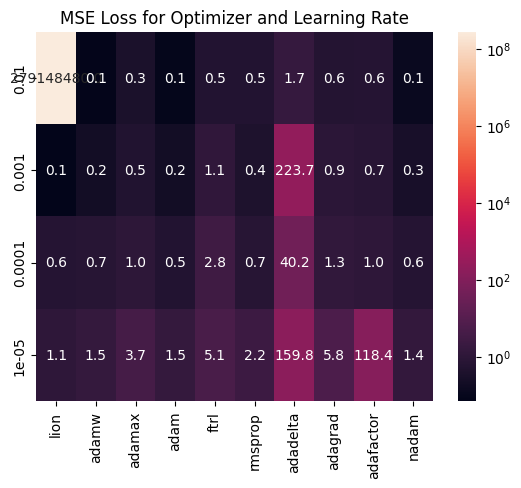

In [133]:
from matplotlib.colors import LogNorm
sns.heatmap(
    pd.DataFrame(losses),
    annot=True,
    fmt=".1f",
    norm=LogNorm()
)
plt.title('MSE Loss for Optimizer and Learning Rate')
ax.set_xlabel('Optimizer')
ax.set_ylabel('Learning Rate')
plt.show()

Clearly, `Lion`, `Adam`/`AdamW`, and `Nadam` have the best, smallest, and most consistent losses, so these are what will move on to our hyperparamter tuning stage.

Remark: Recall from the documentation we cited above that `Lion` needs 10x smaller learning rate than `AdamW`, indeed, this appears to be the case. However, as the documentation also describes, `Lion` essentially supersedes `Adam`/`AdamW`, and our testing shows that `Lion` does train about 25% faster than `AdamW`. Note: since benchmarking time is out of scope for this project, we will not attach said code here.

#### Layers and Nodes Tuning

Similar to optimizer tuning, our goal here is to determine what order of magnitude for layers and nodes are most sensible for our NN, in order to reduce the problem search space for our final GridSearch. To do this, we propose the following formulation: We will loop through a set list of number of nodes per layer, and number of layers, and create a heatmap of loss like before.

In [128]:
layers = np.arange(5,15)
nodes = np.arange(50,210,20)

losses2 = {}
for layer in layers:
    losses2[layer] = {}
    for node in nodes:
        model = Sequential()
        model.add(Input(shape=(X_features.shape[1],)))
        for _ in range(layer):
            model.add(Dense(node))
            model.add(LeakyReLU(negative_slope=0.01))
        model.add(Dense(1)) # output layer

        model.compile(
            optimizer=Lion(learning_rate=0.0001), # We use Lion here for its speed
            loss='mean_absolute_error'
        )

        history = model.fit(
            X_features[0:1000], # we take a sample to speed it up
            y.head(1000),
            epochs=20, # few epochs to speed this up
            batch_size=16,
            verbose=0
        )
        losses2[layer][node] = history.history['loss'][-1]

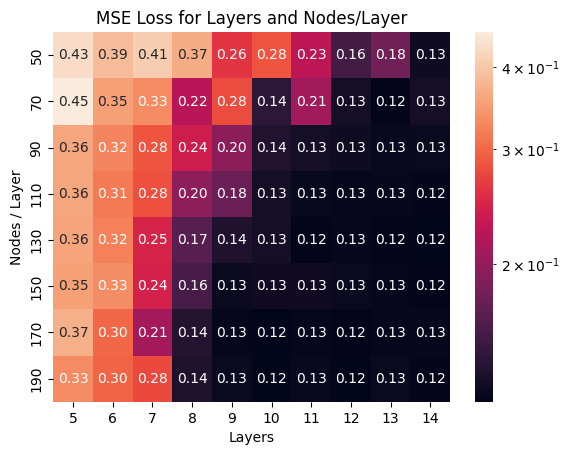

In [131]:
ax = sns.heatmap(
    pd.DataFrame(losses2),
    annot=True,
    fmt=".2f",
    norm=LogNorm()
)
plt.title('MSE Loss for Layers and Nodes/Layer')
ax.set_xlabel('Layers')
ax.set_ylabel('Nodes / Layer')
plt.show()

Here, we see how our model's training loss decreases as we add more layers adn more nodes. This is consistent with the fitting graph - as we add more layers or nodes, we increase model complexity, and run the risk of overfitting our training data. This means we need to hyperparameter tune in the region between **8-11 layers and 90-130 nodes**, since this is when the loss starts to go down, without it being too high that we run the risk of overfitting.

#### Final Hyperparameter Tuning

To summarize, we have the following hyperparamters to tune:
- Optimizer: `AdamW`, `Nadam`, or `Lion`
- Learning Rate: `0.00001` - `0.0001`
- Layers: `8`-`11`
- Nodes/layer: `90-130`
- Activation Function: `relu`,`sigmoid`,`tanh` (for hidden layers)

Thus, let's define a Keras Tuner to automatically report the best combination. We remark that code will not take an unfathomable number of resources since we had already dramatically limited the problem scope in the previous two sections.

In [147]:
import keras_tuner as kt
hp = kt.HyperParameters()

def build_hp_NN(hp):
    model = Sequential()
    model.add(Input(shape=(X_features.shape[1],)))

    num_layers = hp.Int('num_layers', min_value=8, max_value=11)
    for _ in range(num_layers):
        model.add(Dense(
            hp.Int('num_nodes', min_value=90, max_value=130, step=10),
            activation=hp.Choice('activation_func', ['relu','sigmoid','tanh'])
        ))
        model.add(LeakyReLU(negative_slope=0.01))

    model.add(Dense(1))

    optimizer_dict = {'lion': Lion, 'adamw': AdamW, 'nadam': Nadam}
    optimizer_class = optimizer_dict[hp.Choice('optimizer_class', ['lion','adamw','nadam'])]
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling="log")
    model.compile(
        optimizer=optimizer_class(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )
    return model

In [148]:
tuner = kt.GridSearch(
    build_hp_NN,
    objective='val_mean_squared_error',
    executions_per_trial=1,
    directory='NN_tuner',
    project_name='NN_model',
    overwrite=True
)

In [152]:
tuner.search(
    X_features[0:1000],
    y.head(1000),
    epochs=1,
    validation_split=0.2,
    verbose=1
)

In [666]:
y_pred = model.predict(X_features)
mean_absolute_error(y, np.clip(y_pred, a_min=0, a_max=5))

6787/6787 ━━━━━━━━━━━━━━━━━━━━ 4s 595us/step


0.18138174396223417

In [667]:
pd.Series(np.clip(y_pred, a_min=0, a_max=5).ravel()).describe()

count    217171.000000
mean          4.888960
std           0.080024
min           0.252998
25%           4.851997
50%           4.897932
75%           4.939176
max           5.000000
dtype: float64

In [668]:
y.describe()

count    217171.000000
mean          4.783007
std           0.372480
min           0.000000
25%           4.730000
50%           4.890000
75%           5.000000
max           5.000000
Name: review_scores_rating, dtype: float64

### Model Evaluation

We now do 10-fold cross validaton and report the metrics for each fold.

In [515]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

scores = {}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X)):

    X_train_fold, X_test_fold = X_features[train_index], X_features[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model = 0

    model = KerasRegressor(
        make_model,
        loss='mean_squared_error',
        epochs=10,
        batch_size=32,
        verbose=1,
        optimizer=Lion(learning_rate=0.001),
        callbacks=[ModelCheckpoint('model.keras',monitor='loss')]
    )

    model.fit(X_train_fold, y_train_fold)
    y_train_pred_fold = model.predict(X_train_fold)
    y_test_pred_fold = model.predict(X_test_fold)
    
    scores[i] = {}
    scores[i]['train'] = {
        'mean_squared_error': mean_squared_error(y_train_fold, y_train_pred_fold),
        'mean_absolute_error': mean_absolute_error(y_train_fold, y_train_pred_fold),
        'r2_score': r2_score(y_train_fold, y_train_pred_fold)
    }
    scores[i]['test'] = {
        'mean_squared_error': mean_squared_error(y_test_fold, y_test_pred_fold),
        'mean_absolute_error': mean_absolute_error(y_test_fold, y_test_pred_fold),
        'r2_score': r2_score(y_test_fold, y_test_pred_fold)
    }

Epoch 1/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 822us/step - loss: 0.4759
Epoch 2/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 817us/step - loss: 0.1668
Epoch 3/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 819us/step - loss: 0.2600
Epoch 4/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 839us/step - loss: 418194752.0000
Epoch 5/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 835us/step - loss: 0.1390
Epoch 6/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 847us/step - loss: 0.1391
Epoch 7/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 827us/step - loss: 0.1372
Epoch 8/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 818us/step - loss: 0.1387
Epoch 9/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 817us/step - loss: 0.1384
Epoch 10/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 822us/step - loss: 0.1412
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 4s 614us/step
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
Epoch 1/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 801us/step - loss: 23.0112
Epoch 2/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 836us/step - loss: 23.0047
Epoch 3/10
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 5s 805u

In [519]:
new_scores_df = pd.DataFrame.from_dict(
    {(i, k): scores[i][k]
    for i in scores.keys()
    for k in scores[i].keys()},
    orient='index'
)
new_scores_df

mean_squared_error  mean_absolute_error    r2_score
0 train            0.140889             0.216439   -0.018779
  test             0.144876             0.218719   -0.014719
1 train           23.011792             4.782489 -163.856975
  test            23.052857             4.787667 -174.837453
2 train            0.138847             0.213932   -0.000067
  test             0.137878             0.211612   -0.000127
3 train           23.016815             4.783053 -164.329839
  test            23.007646             4.782593 -170.128219
4 train            0.139162             0.213912   -0.000060
  test             0.135046             0.211786   -0.000234
5 train           23.019873             4.783535 -166.211167
  test            22.980127             4.778260 -153.899820
6 train           23.015059             4.782874 -164.365556
  test            23.023456             4.784208 -169.782395
7 train           23.018680             4.783342 -165.415551
  test            22.990862             4.779995 -160.327445
8 train            0.138820             0.219173   -0.002158
  test             0.140969             0.220727   -0.001839
9 train           23.014322             4.782854 -165.015054
  test            23.030087             4.784385 -163.793014